## Check Paths

## Installing Libraries

In [ ]:
!pip install -U efficientnet
import albumentations as albu

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import tensorflow as tf
from keras.utils import to_categorical
import cv2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import efficientnet.keras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
import albumentations as albu
import seaborn as sns
import pickle
import joblib


## Loading the CIFAR-100 Dataset

In [ ]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='latin1')
    return dict

## Metadata
#### Meta file has a dictionary of fine labels and coarse labels.

In [ ]:
metadata_path = '../input/cifar100/meta'
metadata = unpickle(metadata_path)

In [ ]:
pd.set_option('display.max_rows', 110)
sub_category = pd.DataFrame(metadata['fine_label_names'], columns = ['Sub_category'])
sub_category

,Sub_category
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
5,bed
6,bee
7,beetle
8,bicycle
9,bottle


In [ ]:
sub_category.to_csv("sub_categories.csv")

In [ ]:
super_category = pd.DataFrame(metadata['coarse_label_names'], columns = ['Super_Category'])
super_category

,Super_Category
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


In [ ]:
super_category.to_csv("super_categories.csv")

## Train Data

In [ ]:
train_path = '../input/cifar100/train'
train = unpickle(train_path)
train.keys()

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])

In [ ]:
for keys in train:
    print(keys, type(train[keys]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [ ]:
train['batch_label']

'training batch 1 of 1'

In [ ]:
len(train['filenames'])

50000

In [ ]:
np.unique(train['fine_labels'])    

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

100 different fine labels for the images (0 to 99)

In [ ]:
np.unique(train['coarse_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

10 different coarse labels for the images (0 to 9)

In [ ]:
print(len(train['data']))
print(train['data'][0].shape)

50000
(3072,)


50000 images in the training dataset and each image is a 3 channel 32 32 pixel image (32 32 * 3 = 3072)

## Test Data

In [ ]:
test_path = '../input/cifar100/test'
test = unpickle(test_path)
test.keys()
for keys in test:
    print(keys, type(test[keys]))


filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [ ]:
len(test['filenames'])

10000

In [ ]:
test['batch_label']

'testing batch 1 of 1'

In [ ]:
np.unique(test['fine_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
np.unique(test['coarse_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
print(len(test['data']))
print(test['data'][0].shape)

10000
(3072,)


## Spliting Train and Test Data

In [ ]:
X_train = train['data']
print("X_train: ",'\n\n', X_train, '\n')
print("Length: ",len(X_train))

X_train:  

 [[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]] 

Length:  50000


In [ ]:
X_test = test['data']
print("X_test: ",'\n\n', X_test, '\n')
print("Length: ",len(X_test))

X_test:  

 [[199 196 195 ... 215 211 183]
 [113  88  72 ...  96  80  67]
 [ 61  61  67 ... 189 115  89]
 ...
 [ 24  24  22 ...  20  54  54]
 [ 86  93  28 ... 119 115 109]
 [246 240 214 ... 114 141 118]] 

Length:  10000


In [ ]:
y_train = train['fine_labels']

In [ ]:
y_test = test['fine_labels']

## Transform

In [ ]:
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test = test['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

## Explore Images in Dataset

In [ ]:
rand_img = np.random.randint(0, len(X_train))
rand_img

26560

Image Number Selected: 35144
Image Shape: (32, 32, 3)
Image Super Category Number: 14
Image SuperCategory Name: People
Image Sub-Category Number: 46
Image Sub-Category Name: man


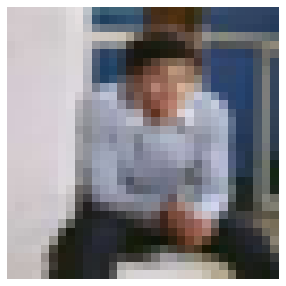

In [ ]:
rcParams['figure.figsize'] = 5,5

img = np.random.randint(0, len(X_train))

plt.imshow(X_train[img])

plt.axis('off')

print("Image Number Selected: {}".format(img))
print("Image Shape: {}".format(X_train[img].shape))
print("Image Super Category Number: {}".format(train['coarse_labels'][img]))
print("Image SuperCategory Name: {}".format(super_category.iloc[train['coarse_labels'][img]][0].capitalize()))
print("Image Sub-Category Number: {}".format(train['fine_labels'][img]))
print("Image Sub-Category Name: {}".format(sub_category.iloc[train['fine_labels'][img]][0]))

# print("Shape of image : {}".format(X_train[img].shape))
# print("Image category number: {}".format(train['coarse_labels'][img]))
# print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
# print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
# print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

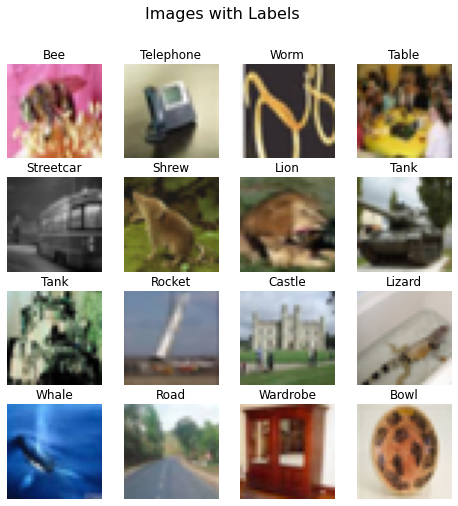

In [ ]:
rcParams['figure.figsize'] = 8,8

nrow = 4
ncol = 4

img = np.random.randint(0, len(X_train), nrow*ncol)
#img

fig, axes = plt.subplots(nrow, ncol)
plt.suptitle("Images with Labels", fontsize = 16)

for i in range(0, nrow):
    for j in range(0, ncol):
        k = (i*ncol) + j 
        axes[i, j].imshow(X_train[img[k]])
        axes[i, j].set_title(sub_category.iloc[train['fine_labels'][img[k]]][0].capitalize())
        axes[i, j].axis("off")
plt.show()


## Converting Class Vectors to Binary Class Metrics

In [ ]:
n_classes = 100
y_train = to_categorical(y_train, n_classes)


y_test = to_categorical(y_test, n_classes)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Constants

In [ ]:
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 30
batch_size = 8

## Image Preprocessing(Image Manupulation / Image Data Generator)

In [ ]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

### Custom Data Generator class

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels = None, mode = 'fit', batch_size = batch_size, dim = (height, width), channels = channels, n_classes = n_classes, shuffle = True, augment = False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                   albu.VerticalFlip(p = 0.5),
                                   albu.GridDistortion(p = 0.2),
                                   albu.ElasticTransform(p = 0.2)])
        return composition(image = img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [ ]:
train_data_generator = DataGenerator(X_train, y_train, augment = True)
valid_data_generator = DataGenerator(X_test, y_test, augment = False)

# Model
------------------------------------
### Using pre-trained EfficientNetB0

In [ ]:
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = input_shape, classes = n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
optimizer = Adam(lr = 0.0001)

early_stop = EarlyStopping(monitor ='val_loss', mode = 'min', verbose = 1, patience = 10, restore_best_weights = True)

rlrop = ReduceLROnPlateau(monitor ='val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, verbose = 1)

In [ ]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_history = model.fit(train_data_generator,
                            validation_data = valid_data_generator,
                            callbacks = [early_stop, rlrop],
                            verbose = 1,
                            epochs = epochs)

Epoch 1/30
6250/6250 [==============================] - 850s 135ms/step - loss: 3.2801 - accuracy: 0.2341 - val_loss: 1.0266 - val_accuracy: 0.6928
Epoch 2/30
6250/6250 [==============================] - 847s 136ms/step - loss: 1.6034 - accuracy: 0.5623 - val_loss: 0.8588 - val_accuracy: 0.7511
Epoch 3/30
6250/6250 [==============================] - 854s 137ms/step - loss: 1.2904 - accuracy: 0.6403 - val_loss: 0.8380 - val_accuracy: 0.7682
Epoch 4/30
6250/6250 [==============================] - 845s 135ms/step - loss: 1.1229 - accuracy: 0.6793 - val_loss: 0.7838 - val_accuracy: 0.7841
Epoch 5/30
6250/6250 [==============================] - 838s 134ms/step - loss: 1.0031 - accuracy: 0.7073 - val_loss: 0.7932 - val_accuracy: 0.7930
Epoch 6/30
6250/6250 [==============================] - 842s 135ms/step - loss: 0.9135 - accuracy: 0.7368 - val_loss: 0.7704 - val_accuracy: 0.7978
Epoch 7/30
6250/6250 [==============================] - 853s 137ms/step - loss: 0.8394 - accuracy: 0.7545 - val_

In [ ]:
model.save('/kaggle/working/'+'ML_Project_19239model.h5')

In [ ]:
model.save_weights('/kaggle/working/'+'ML_Project_19239model_weights.h5')

## Model Plots (History)

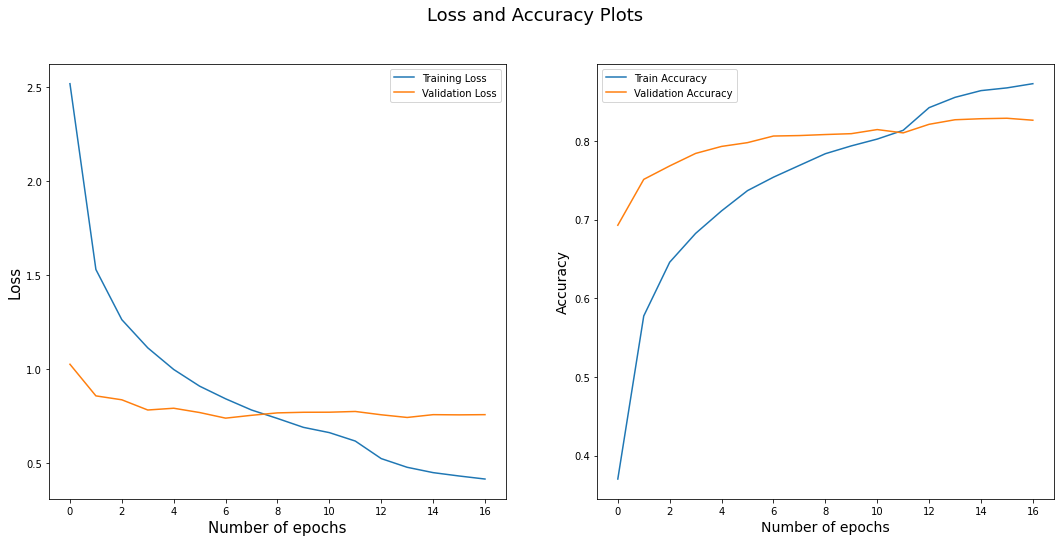

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize = 18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label = 'Training Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label = 'Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label ='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.show()

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_data_generator, verbose = 1)

print('\n')
print("Test or Validation Loss: ", round(valid_loss * 100, 2), '%')
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

1250/1250 [==============================] - 19s 15ms/step - loss: 0.7406 - accuracy: 0.8062


Test or Validation Loss:  74.06 %
Validation Accuracy:  80.62 %


## Model Prediction

In [ ]:
y_pred = model.predict(DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False), verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

test_accuracy = accuracy_score(np.argmax(y_test, axis = 1), y_pred) #tsklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

1250/1250 [==============================] - 17s 13ms/step
Test Accuracy:  80.62 %


## Confusion Matrix

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
print(cm)

[[95  0  0 ...  0  0  0]
 [ 0 88  0 ...  0  0  0]
 [ 0  0 77 ...  0  0  0]
 ...
 [ 0  0  0 ... 90  0  0]
 [ 0  0  5 ...  0 55  0]
 [ 0  0  0 ...  0  0 88]]


In [ ]:
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis = 1), y_pred, target_names = target))

              precision    recall  f1-score   support

  Category 0       0.90      0.95      0.93       100
  Category 1       0.97      0.88      0.92       100
  Category 2       0.55      0.77      0.64       100
  Category 3       0.68      0.67      0.67       100
  Category 4       0.65      0.71      0.68       100
  Category 5       0.88      0.75      0.81       100
  Category 6       0.79      0.91      0.85       100
  Category 7       0.91      0.80      0.85       100
  Category 8       0.93      0.96      0.95       100
  Category 9       0.88      0.91      0.90       100
 Category 10       0.76      0.55      0.64       100
 Category 11       0.58      0.45      0.51       100
 Category 12       0.87      0.82      0.85       100
 Category 13       0.85      0.61      0.71       100
 Category 14       0.92      0.87      0.89       100
 Category 15       0.80      0.87      0.83       100
 Category 16       0.84      0.87      0.86       100
 Category 17       0.95    

## Visualizing the Predictions


In [ ]:
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,55
3,51
4,71


True Label: Streetcar
Predicted Label: Streetcar


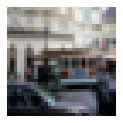

In [ ]:
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(sub_category.iloc[test['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(sub_category.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

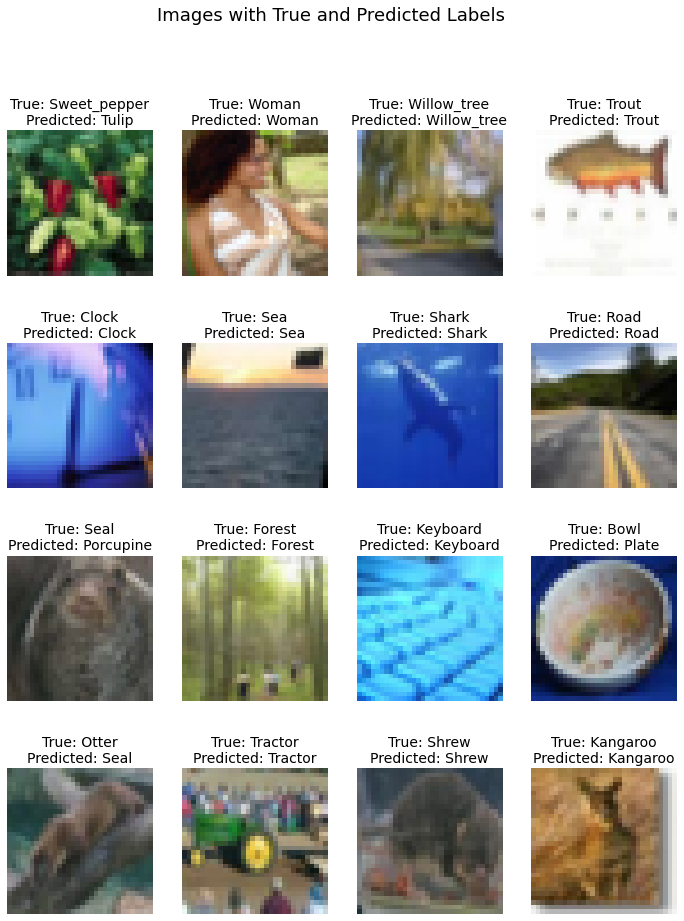

In [ ]:
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col) + j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(sub_category.iloc[test['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(sub_category.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize = 18) 

plt.show()

## Testing the Model

In [ ]:
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    resized_img = resized_img / 255.
    return resized_img

In [ ]:
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

In [ ]:
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

In [ ]:
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(sub_category.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns = ['Label', 'Probability'])  
    
    return df

In [ ]:
def plot_top5_prediction_test_image(test_img):
    
    try:
    
        fig, axes = plt.subplots(1, 2, figsize = (15,4))
        fig.suptitle("Prediction", fontsize = 18)

        new_img = plt.imread(test_img)
        axes[0].imshow(new_img)
        axes[0].axis('off')

        data = df_top5_prediction_test_image(test_img)
        x = df_top5_prediction_test_image(test_img)['Label']
        y = df_top5_prediction_test_image(test_img)['Probability']

        axes[1] = sns.barplot(x = x, y = y, data = data, color ="green")

        plt.xlabel('Label', fontsize=14)
        plt.ylabel('Probability', fontsize=14)

        plt.ylim(0,1.0)

        axes[1].grid(False)
        axes[1].spines["top"].set_visible(False)
        axes[1].spines["right"].set_visible(False)
        axes[1].spines["bottom"].set_visible(False)
        axes[1].spines["left"].set_visible(False)

        plt.show()
    
    except Exception as e:
        print("Check file path or file name")

## Random Images Testing with Model to see Top 5 Predicition

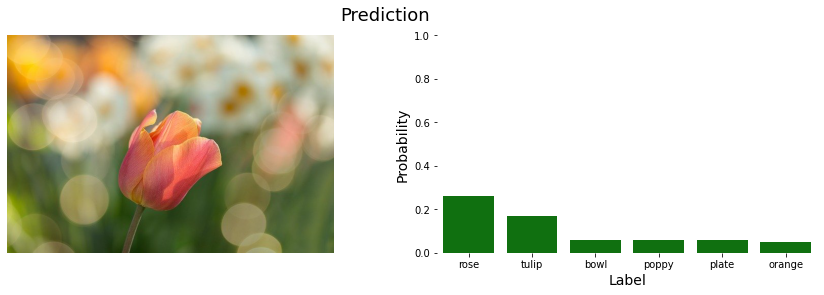

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/flowers/tulip.jpg')

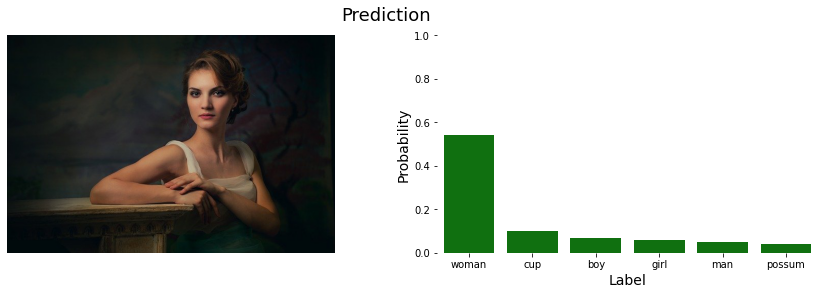

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/person.jpg')

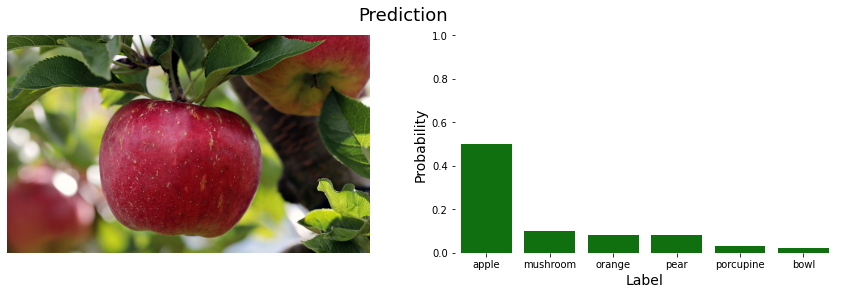

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/fruit.jpg')

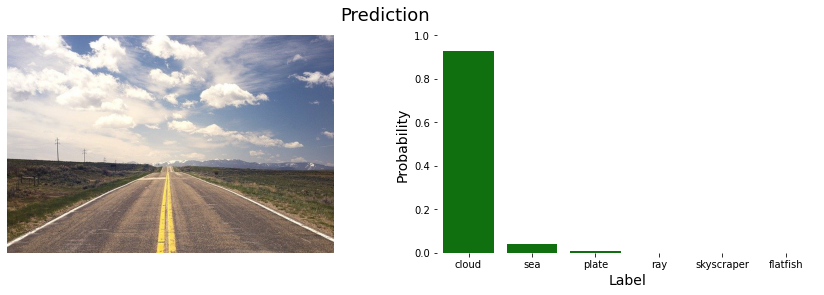

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/street.jpg')

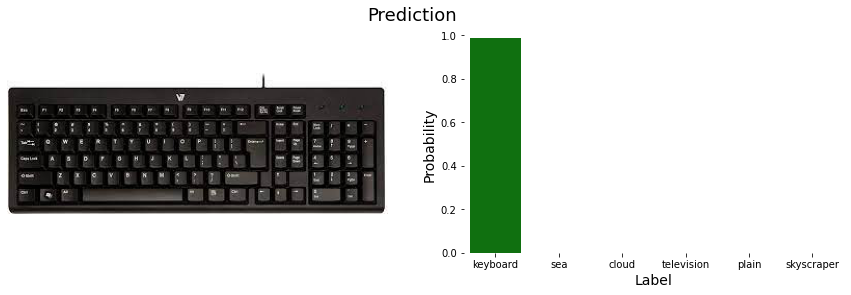

In [ ]:
plot_top5_prediction_test_image('../input/image-for-testing/keyboard.jfif')

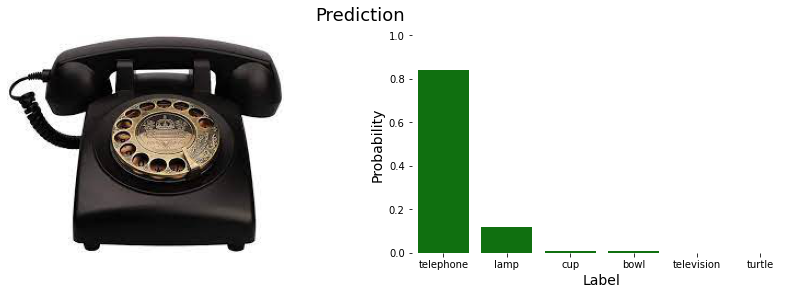

In [ ]:
plot_top5_prediction_test_image('../input/image-for-testing/telephone.jfif')

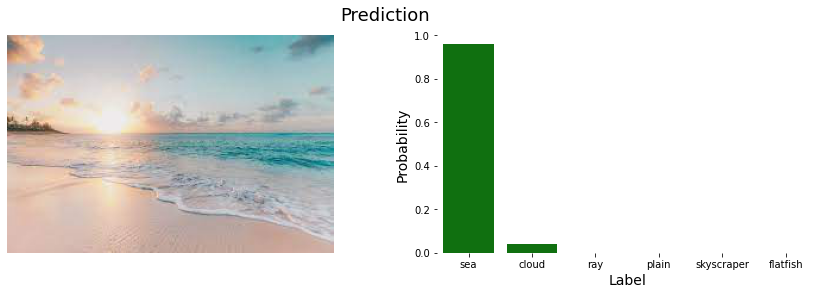

In [ ]:
plot_top5_prediction_test_image('../input/image-for-testing/beach.jfif')

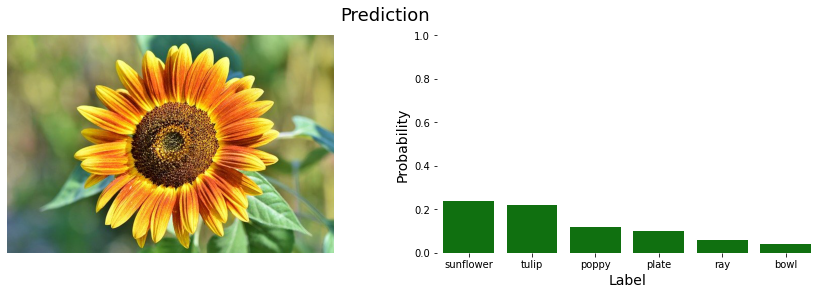

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/flowers/sunflower.jpg')

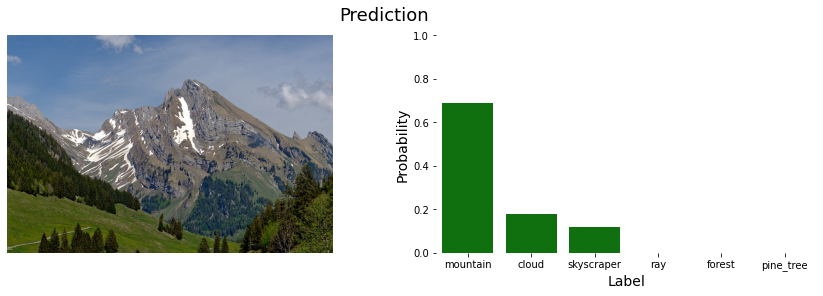

In [ ]:
plot_top5_prediction_test_image('../input/random-image-for-testing-classification/mountain.jpg')